# Project File - APS360 Team 25
Divided into the following section: 
# 
1) Library imports
2) Data imports
3) Model architecture definition
4) Training function definition
5) Model training
6) Model testing

## Library imports 
(Place all library imports here)

In [1]:
#KP - I just added the main ones from the labs.
import matplotlib.pyplot as plt
import numpy as np

#import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import time # Tracking model training time.

# Install mido for Data importing
# !pip install mido;
import mido
from mido import MidiFile, Message, MidiTrack, MetaMessage
import os
import random
import copy

In [2]:
#Set working directory if required:
os.chdir('D:\engsci\year 3\CLASS\APS360\Project') #Sets current working directory!

## Data imports
#### MIDI reading functions

In [3]:
def CountTracks(directory):          #Count files and tracks in folder
    trackCount = 0
    fileCount = 0
    for file in os.listdir(directory):
        if file.endswith(".midi"):
            fileCount += 1
            midiDir = MidiFile(directory+"/"+file)
            for track in midiDir.tracks:
                trackCount += 1
    print(fileCount+" files")
    print(trackCount+" tracks")

    
def PrintMessages(mid):                # print midi messages
    for i, track in enumerate(mid.tracks):
        print('Track {}: {}'.format(i, track.name))
        for msg in track:
            print(msg)

            
def PrintSomeMessages(mid):             #print first 200 midi messages
    track = mid.tracks[1]
    for i,msg in enumerate(track):
        if i < 200:
            print(msg)
            
def PrintMetaMessages(mid):             #print fmeta messages
    track = mid.tracks[0]
    for i,msg in enumerate(track):
        print(msg)

def cleanupMessages(mid):              #removes non-note messages by force
    track = mid.tracks[1]
    track2 = []
    for msg in track:
        if msg.type == "note_on":
            track2.append(msg)
    mid.tracks[1] = track2

#### MIDI to Numpy code

In [4]:
def Midi2NumpyNoSustain(mid, track0=1):                                #converts to numpy array removing non-note messages
    track = mid.tracks[track0]                           #0th track only contains meta-messages, all notes on 1st track
    notes = np.empty([0,4])
    time = 0
    for msg in track:
        if msg.type == "note_on":                   # only count "note" messages - other inputs i.e. foot pedals are ignored
            notes = np.append(notes,np.array([[msg.note, msg.velocity, msg.time + time, 0]]),axis=0)         # (note, velocity, time, sustain)
            time = 0
        elif msg.type == "note_off":
            notes = np.append(notes,np.array([[msg.note, 0, msg.time + time, 0]]),axis=0)         # (note, velocity, time, sustain)
            time = 0        
        else:
            time += msg.time                        #adjust time when removing other messages
    return notes


def NumpyGetSustain(note):
    notes = np.copy(note)
    for i, msg in enumerate(notes):
        if msg[1] > 0:                            # if velocity is not 0
            j = 1
            sustain = 0
            while msg[0] != notes[i+j][0]:        # while note values are different
                sustain += notes[i+j][2]
                j += 1                            #search for next message with same note i.e. message telling that note was released
            notes[i,3] = sustain + notes[i+j][2]
    time = 0
    for i, msg in enumerate(notes):
        if msg[1] > 0:
            notes[i,2] += time
            time = 0
        else:
            time += msg[2]                        #adjust time
    notes = notes[notes[:,1] > 0]                 #filter for notes with positive velocities (note presses)
    return notes

def NumpyNormalize(note, oneHot=False, full=False):                         #normalize all values to 0-1
    notes = np.copy(note)
    
    if oneHot:
        if full:
            notes[:,88] /= 128
            notes[:,89] /= 40000
            notes[:,90] /= 40000
        else:
            notes[:,12] /= 11
            notes[:,13] /= 128
            notes[:,14] /= 40000
            notes[:,15] /= 40000
    else:
        notes[:,0] /= 128
        notes[:,1] /= 128
        notes[:,2] /= 40000
        notes[:,3] /= 40000       
    return notes

def NumpyOneHot(note):
    notes = np.copy(note)
    oneHot = np.zeros([len(notes),16])
    oneHot[:, 13:] = notes[:, 1:]
    names = notes[:,0]
    namesOct = names%12
    oneHot[:,12] = (names-(namesOct))/12
    
    for i, name in enumerate(namesOct):
        oneHot[i,name.astype(int)] = 1
    
    return oneHot

def NumpyNotesOneHot(note):
    notes = np.copy(note)
    
    oneHot = np.zeros([len(notes),91])
    oneHot[:, 88:] = notes[:, 1:]
    names = notes[:,0]-21
    #namesOct = names%12
    #oneHot[:,12] = (names-(namesOct))/12
    
    for i, name in enumerate(names):
        oneHot[i,name.astype(int)] = 1
    
    return oneHot

def Midi2Numpy(path, oneHot=False, track0=1): # full midi to numpy conversion
    mid = MidiFile(path)
    notes = Midi2NumpyNoSustain(mid, track0=track0)
    cleanNotes = NumpyGetSustain(notes)
    
    if oneHot:
        cleanNotes = NumpyOneHot(cleanNotes)
    
    normNotes = NumpyNormalize(cleanNotes, oneHot=oneHot)
    return normNotes

#### Numpy to MIDI code

In [5]:
def NumpyDenormalize(note): # interpret all values from 0-1 to normal values
    notes = np.copy(note)    
    if notes.shape[1] == 16: # if encode as one-hot
        notes[:,12] *= 11 # octave
        notes[:,13] *= 128 # vel
        notes[:,14] *= 40000 # time
        notes[:,15] *= 40000 # sustain
        
        notes = NumpyEncode(notes) #encode back as original 4-variable format
        
    elif notes.shape[1] == 91: # if encoded as one-hot w/o octave
        notes[:,88] *= 128
        notes[:,89] *= 40000
        notes[:,90] *= 40000
        
        #print(notes)
        
        notes = NumpyEncodeNotes(notes)
        
    else:
        notes[:,0] *= 128
        notes[:,1] *= 128
        notes[:,2] *= 40000
        notes[:,3] *= 40000       
    return notes.astype(int)

def NumpyEncode(note): # convert back from one-hot encoding
    notes = np.copy(note)    
    encoded = np.zeros([len(notes),4]) # create array   
    encoded[:, 1:] = notes[:, 13:] # set vel/time/sustain
    encoded[:, 0] = notes[:,12]*12 # add octave value
    
    for i in range(len(notes)):
        encoded[i,0] += np.argmax(notes[i,:12])
    
    return encoded

def NumpyEncodeNotes(note): # convert back from one-hot encoding
    notes = np.copy(note)    
    encoded = np.zeros([len(notes),4])
    
    encoded[:, 1:] = notes[:, 88:] # set vel/time/sustain
    
    for i in range(len(notes)):
        encoded[i,0] += np.argmax(notes[i,:88])+21
    
    return encoded

def NumpySequence(notes): # put all notes into a "timeline" i.e.: time values of [10, 20, 10, 30] become [10, 30, 40, 70]
    sequenced = np.copy(notes)                      # this allows us to easily add vel=0 notes in any order since we can later sort them by time
    for i, msg in enumerate(sequenced):
        if i > 0:
            sequenced[i,2] += sequenced[i-1,2]
    return sequenced

def NumpyAddOffNotes(sequenced): # add vel=0 notes from sustain into sequenced timeline
    withOff = np.copy(sequenced)
    for msg in sequenced:
        offNote = np.array([[msg[0], 0, msg[2] + msg[3], 0]])
        withOff = np.append(withOff, offNote, axis=0)
    #withOff = np.sort(withOff,axis=0)
    withOff = withOff[withOff[:,2].argsort()] # sort by time
    return withOff

def NumpyUnsequence(notes): # revert time value to "time since last message"
    unsequenced = np.copy(notes)
    for i, msg in reversed(list(enumerate(unsequenced))):
        unsequenced[i,3] = 0
        if i > 0:
            unsequenced[i,2] -= unsequenced[i-1,2]
    return unsequenced

def Numpy2MidiDirect(array):    #make MIDI object from numpy
    #Start with initializing a new Mido Track:
    mid = MidiFile()
    track0 = MidiTrack()
    track1 = MidiTrack()
    
    track0.append(MetaMessage('set_tempo', tempo=500000, time=0)) #MetaMessages not necessary but are present in used files
    track0.append(MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    track0.append(MetaMessage('end_of_track', time=1))
    
    track1.append(Message('program_change', channel=0, program=0, time=0))
    
    for i,note in enumerate(array):         # Get the index and the note. Array must be int array
        j = 1
        track1.append(Message('note_on',note = array[i,0], velocity = array[i,1],time = array[i,2])) # Add the note to the track.

    mid.tracks.append(track0)
    mid.tracks.append(track1)
    return mid

def Numpy2Midi(notes, name): # full numpy to midi conversion, saving result to [name].midi
    denorm = NumpyDenormalize(notes)
    seq = NumpySequence(denorm)
    off = NumpyAddOffNotes(seq)
    unseq = NumpyUnsequence(off)
    mid = Numpy2MidiDirect(unseq)
    mid.save(name + ".midi")

In [6]:
def splitTrack(midiFileName, inputDir, outputDir):
    mid = MidiFile(inputDir+midiFileName+".midi")
    for t, track in enumerate(mid.tracks):
        program, channel = findInstrument(track)        
        if len(track) < 200 or program == -1:
            continue
        trackMidi = copy.copy(mid)
        indices = [t]
        trackMidi.tracks = [trackMidi.tracks[x] for x in indices]
        #trackMidi.tracks.append(track)
        trackMidi.save(outputDir + midiFileName + "_prog{:0>3d}_chan{:0>2d}.midi".format(program,channel))

def splitAllTracks(inputDir, outputDir, first=0): # very bad code -  doesnt remove the .midi in the middle lol
    for i,f in enumerate(os.listdir(inputDir)):
        if i >= first:
            if len(f) <7:
                continue
            splitTrack(f[:7],inputDir,outputDir)

            if i % 1 == 0:
                print(f)
        
def findInstrument(track):
    count = 0
    infoMsg = 0
    
    for msg in track:
        if msg.type == "program_change":
            count += 1
            infoMsg = msg
    
    if count >= 1:
        if infoMsg.channel == 9 or count == 1:
            return infoMsg.program, infoMsg.channel
        else: 
            return -1, -1
    else:
        return -1, -1

In [7]:
#splitAllTracks("data/jazz/","data/jazz/tracks/")

#### Generatng tensor dataset from CSVs

In [8]:
def Numpy2Dataset(notes, tgt, num=100,skip=200): # make list of sumpy arrays
    samples = []
    targets = []
    i = 0
    while i+num <= len(notes):
        samples.append(notes[i:i+num])
        targets.append(tgt)
        i += skip
    return samples, targets

def SampleAllNumpy(dataPath): # generate samples from all saved CSVs
    allSamples = []
    allTargets = []

    for i,f in enumerate(os.listdir(dataPath)):
        notes = np.genfromtxt(dataPath+f, delimiter=',')
        tgt = GetGroup(f)
                             
        samples, targets = Numpy2Dataset(notes, tgt)
        allSamples += samples
        allTargets += targets
        if i % 100 == 0:
            print(i)
            
    random.seed(0)
    random.shuffle(allSamples)
    random.seed(0)
    random.shuffle(allTargets) # shuffle samples and targets in the exact same way
    
    return allSamples, allTargets

def SaveSamplesTensor(samples, targets, outputPath, name="Notes_Dataset"): # save tensor
    tens = torch.Tensor(samples)
    targ = torch.Tensor(targets)
    dataset = TensorDataset(tens,targ)
    torch.save(dataset, outputPath+name+".pt")
    return tens   

def SaveAllSamples(dataPath, outputPath, name="Notes_Dataset"): # save dataset tensor
    samples, targets = SampleAllNumpy(dataPath)
    SaveSamplesTensor(samples, targets, outputPath, name)
    
def SplitSamples(dataset, ranges):
    torch.maual_seed(0)
    trainData, valData, testData = random_split(oneHotDataset, splitRange)
    return trainData, valData, testData 

In [9]:
def ProgramGroup(program, channel):
    if channel == 9:
        return 0 # drums
    if program < 8:
        return 1 # piano
    if program < 16:
        return 8 # pitched percussion
    if program < 24:
        return 7 # organ
    if program < 32:
        return 3 # guitar
    if program < 40:
        return 2 # bass
    if program < 48:
        return 9 # string
    if program < 56:
        return 10 # ensemble
    if program < 64:
        return 4 # brass 
    if program < 72:
        return 5 # reed
    if program < 80:
        return 11 # pipe
    if program < 88:
        return 6 # synth lead
    if program < 96:
        return 12 # synth pad
    if program < 104:
        return 13 # synth efects
    if program < 112:
        return 14 # ethnic
    if program < 120:
        return 15 # percusson
    else:
        return 16 # other 
    
def GetProgram(name):
    prog = name[12:15]
    chan = name[20:22]
    return int(prog), int(chan)

def GetGroup(name):
    prog, chan = GetProgram(name)
    group = ProgramGroup(prog, chan)
    return(group)

#### Bulk data conversion code - COMMENT OUT IF NOT IN USE!!!

In [10]:
#SaveAllSamples("data/jazz/tracks_numpy/train/","data/","trainDataClass") #save all into tensor
#SaveAllSamples("data/jazz/tracks_numpy/val/","data/","valDataClass") #save all into tensor
#SaveAllSamples("data/jazz/tracks_numpy/test/","data/","testDataClass") #save all into tensor

# oneHotDataset = torch.load("data/onehot_data/onehot.pt")

# splitProp = np.array([0.9, 0.05 , 0.05]) # 90/5/5% split
# splitRange = len(oneHotDataset)*splitProp
# splitRange[0] += 1                           # so numbers add up
# splitRange = splitRange.astype(int)

# length = len(oneHotDataset)
# a = 0.9*length
# a = int(a)

# b = 0.95*length
# b = int(b)

# tiny = oneHotDataset[:30]
# train = oneHotDataset[:a]
# val = oneHotDataset[a:b]
# test = oneHotDataset[b:]

# tinyData = TensorDataset(tiny[0].clone(), tiny[1].clone())
# trainData = TensorDataset(train[0].clone(),train[1].clone())
# valData = TensorDataset(val[0].clone(),val[1].clone())
# testData = TensorDataset(test[0].clone(),test[1].clone())

# torch.save(tinyData,"data/onehot_data/tinyDataOneHot.pt")
# torch.save(trainData,"data/onehot_data/trainDataOneHot.pt")
# torch.save(valData,"data/onehot_data/valDataOneHot.pt")
# torch.save(testData,"data/onehot_data/testDataOneHot.pt")

In [11]:
#a = torch.load("data/va.pt")

In [12]:
# for img, label in iter(a):
#     #print(img)
#     print(label)
#     print()

In [13]:
# IMPORTANT: COMMENT OUT IF NOT IN USE TO AVOID ACCIDENTS!!!!!!!

# Getting CSVs from MIDI data and processed data from CSVs
# Processed MIDI does not contain program messages and so are a good measure of what output SHOULD look like in a perfect world

# dataPath = "data/jazz/tracks/"
# outputPath = "data/jazz/tracks_numpy/"
# #processedPath = "data/MIDI_files_processed/"

# for i,f in enumerate(os.listdir(dataPath)):
#     if i > 2700:
#         notes = Midi2Numpy(dataPath+f,track0=0)
#         np.savetxt(outputPath + f[:22]+".csv",notes,delimiter=",")
#     #Numpy2Midi(notes, processedPath + "MIDI_{:04d}".format(i))
#     #break
    
#     if i % 200 == 0:
#         print(i)

In [14]:
# IMPORTANT: COMMENT OUT IF NOT IN USE TO AVOID ACCIDENTS!!!!!!!

# Getting CSVs from MIDI data and processed data from CSVs
# Processed MIDI does not contain program messages and so are a good measure of what output SHOULD look like in a perfect world

# dataPath = "data/jazz/tracks/"
# outputPath = "data/jazz/tracks_numpy/"
# #processedPath = "data/MIDI_files_processed/"

# for i,f in enumerate(os.listdir(dataPath)):
#     if i == 47:
#         print(f)
#         testMidi = MidiFile(dataPath+f)
#         #PrintMessages(testMidi)
#         print(GetGroup(f))
#     #Numpy2Midi(notes, processedPath + "MIDI_{:04d}".format(i))
#     #break
    
#     if i % 100 == 0:
#         print(i)

In [15]:
# dataPath = "data/numpy_files/"  # one-hot encoding on CSVs
# outputPath = "data/numpy_full/"

# for i,f in enumerate(os.listdir(dataPath)):
#     notes = np.genfromtxt(dataPath+f, delimiter=',')
#     notes = NumpyDenormalize(notes)
#     notes = NumpyNotesOneHot(notes)
#     notes = NumpyNormalize(notes, oneHot=True, full=True)
#     np.savetxt(outputPath + "MIDI_{:04d}.csv".format(i),notes,delimiter=",")
#     if i % 100 == 0:
#         print(i)

## Baseline Model Code
#### getting available notes

In [16]:
def GetAllNotesMajor(root):# Get all used notes in major scale of root=root
    notes = []
    intervals = [2,2,1,2,2,2,1]
    
    while root > 24: #bring down to lowest used octave
        root -= 12
    
    n = root
    notes.append(n)
    while n < 84: #up to higherst used note
        for i in intervals:
            n += i
            notes.append(n)   
    return notes    


def GetRangeMajor(notes, low, high): # Get all notes within range
    lowIndex = notes.index(low)
    highIndex = notes.index(high)
    
    return notes[lowIndex:highIndex+1]   

#### Piece Class
##### represents whole output from all 4 voices

In [17]:
class Piece: # Entire baseline model compostion - composed of 4 voices soprano, alto, tenor, bass (SATB)
    def __init__(self, barNum=16, root=60):# 16 bars in C major
        self.root = root # root note
        self.allNotes = GetAllNotesMajor(self.root) # all notes on major scale
        self.barNum = barNum # number of bars
        
        self.soprano = Voice(self.allNotes,60,84,speed=8) # SATB
        self.alto = Voice(self.allNotes,48,72)
        self.tenor = Voice(self.allNotes,36,60)
        self.bass = Voice(self.allNotes,24,48)
          
        self.notes = np.empty([0,4]) #notes output
        
        self.pieceChords = [] # chords
        
        self.chords = np.array([ # common classical C major chords
            [ 0,  4,  7,  0],# I
            [ 2,  5,  9,  2],# ii
            [ 4,  7, 11,  4],# iii
            [ 5,  9, 0,  5],# IV
            [ 7, 11, 2,  7],# V
            [ 9, 0, 4,  9],# vi
            [11, 2, 5, 11],# vii dim
            [ 2,  5,  9, 0],# ii7
            [ 5,  9, 0, 4],# IVmaj7
            [ 7, 11, 2, 5],# V7
            [11, 2, 5, 9]])# vii7 half-dim
        
    def GenerateSoprano(self): # Generate soprano line
        self.soprano.GenerateLine(self.soprano.speed*self.barNum)
        
    def GenerateAlto(self): # Generate alto line from chords
        self.alto.GenerateChordLine(self.pieceChords)
        
    def GenerateTenor(self): # see alto
        self.tenor.GenerateChordLine(self.pieceChords)
        
    def GenerateBass(self): # see alto
        self.bass.GenerateChordLine(self.pieceChords)
        
        
    
    def ChooseChord(self, sopNote): # Choose a fitting chord for soprano note
        while sopNote >= 12:
            sopNote -= 12
        
        goodChords = np.empty([0,4])
        
        for chord in self.chords:
            if (chord==sopNote).sum() > 0:
                goodChords = np.append(goodChords,[chord],axis=0)
        
        chosenChord = goodChords[random.randint(0,len(goodChords)-1)]
        chosenChord = np.sort(np.unique(chosenChord))
        
        i = 12
        chordNotes = chosenChord
        while i < 120:
            chordNotes = np.append(chordNotes, chosenChord+i)
            i += 12
        
        return(chordNotes)
    
    def GetChords(self): # select all chords in piece
        for i, note in enumerate(self.soprano.notes):
            if i % 2 == 0:
                sopNote = note[0]
                chord = self.ChooseChord(sopNote)
                self.pieceChords.append(chord)
                
    def Normalize(self): # normalize all values to 0-1
        for i, msg in enumerate(self.notes):
            self.notes[i,0] = msg[0]/128
            self.notes[i,1] = msg[1]/128
            self.notes[i,2] = msg[2]/40000
            self.notes[i,3] = msg[3]/40000
                
    def GenerateLines(self): # Generate all SATB lines and joins them - entire baseline model
        self.GenerateSoprano()
        self.GetChords()
        self.GenerateAlto()
        self.GenerateTenor()
        self.GenerateBass()
        self.joinLines()
        self.OffsetTime(20)
        self.Normalize()
        
        return self.notes
        
    def InsertLine(self, starting, inserted, startIndex, skipIndex): # join 2 lines
        base = np.copy(starting)
        ins = np.copy(inserted)
        
        for i,note in enumerate(ins):
            base = np.insert(base, (i*skipIndex)+startIndex, [note], axis=0)
            
        return base
        
    def joinLines(self): # join all SATB lines
        #self.notes = np.copy(self.soprano)
        self.notes = self.InsertLine(self.soprano.notes, self.alto.notes, 1, 3)
        self.notes = self.InsertLine(self.notes, self.tenor.notes, 2, 4)
        self.notes = self.InsertLine(self.notes, self.bass.notes, 3, 5)
        
    def OffsetTime(self, maxChange): # adds random time offsets to make output sound more organic
        for note in self.notes:
            note[2] += random.randint(0,maxChange)
        

#### Voice class
##### Represents individual voices

In [18]:
class Voice: # individual voices
    def __init__(self, allNotes, lowNote, highNote, jump=3, speed=4, time=4096, velocity=64):
        self.range = GetRangeMajor(allNotes,lowNote,highNote) #available ntoes
        self.jump = jump #maximum pitch interval between notes
        self.speed = speed #note length i.e. 4 for quarter, 8 for eighth etc.
        self.time = time #song speed
        self.velocity = velocity #note volume
        self.notes = np.empty([0,4]) #notes output
        self.lowNote = lowNote # lowest note
        self.highNote = highNote # highest note
        self.allNotes = allNotes # all notes in scale
            
        self.duration = self.time / self.speed # time between notes
        
        
    def RandomStartNote(self): # Generate Random first note (for soprano)
        note = random.choice(self.range)
        self.notes = np.append(self.notes,np.array([[note, self.velocity, 0, self.duration]]),axis=0)
        
        
    def RandomJump(self): # Generate Random next note (for soprano)
        lastNote = self.notes[len(self.notes)-1][0] # find last played note
        lastIndex = self.range.index(lastNote)
        
        newIndex = -1
        while newIndex < 0 or newIndex >= len(self.range): # stay in range
            newIndex = lastIndex + random.randint(-self.jump,self.jump)
            
        newNote = self.range[newIndex]
        self.notes = np.append(self.notes,np.array([[newNote, self.velocity, self.duration, self.duration]]),axis=0)
        
        
    def GenerateLine(self, length): # Generate random line (for soprano)
        self.RandomStartNote()
        
        for n in range(length-1):
            self.RandomJump()
            
            
    def clearNotes(self):
        self.notes = np.empty([0,4])
        
    def GetChordNotes(self, chordNotes): # Get useful notes from all chord notes
        chordNotes = chordNotes[chordNotes >= self.lowNote]
        chordNotes = chordNotes[chordNotes <= self.highNote]
        return chordNotes
    
    def ChooseStartChordNote(self, chordNotes): # Choose Random note in chord
        note = random.choice(chordNotes)
        self.notes = np.append(self.notes,np.array([[note, self.velocity, 0, self.duration]]),axis=0)
        
    def ChooseChordNote(self,chordNotes): # Choose suitable next note in chord
        lastNote = self.notes[len(self.notes)-1][0] # find last played note
        
        chordNotes = chordNotes[chordNotes >= lastNote - (self.jump*2)]
        chordNotes = chordNotes[chordNotes <= lastNote + (self.jump*2)]
        newNote = random.choice(chordNotes)
        
        self.notes = np.append(self.notes,np.array([[newNote, self.velocity, 0, self.duration]]),axis=0)
        
    def GenerateChordLine(self, chords): # Generate A/T/B lines
        
        firstChord = self.GetChordNotes(chords[0])
        self.ChooseStartChordNote(firstChord)
        
        for c in chords[1:]:
            chord = self.GetChordNotes(c)
            self.ChooseChordNote(chord)

## Model architecture definition

Set the hyperparameters below:


In [19]:
torch.manual_seed(1)

class LSTMClassifier(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden, n_layers, batch_size):
        super(LSTMClassifier, self).__init__()
        self.name = "LSTMClassifier"
        self.n_features, self.n_classes, self.n_hidden, self.n_layers = n_classes, n_hidden, n_layers, n_features
        self.lstm = nn.LSTM(n_features, n_hidden, n_layers, batch_first=True)
        self.fc = torch.nn.Linear(2*n_hidden, n_classes)

    def forward(self, x):
        # Forward propagate the RNN
        h0 = torch.zeros(self.n_layers,x.size(0),self.n_hidden)
        c0 = torch.zeros(self.n_layers,x.size(0),self.n_hidden)
        if use_cuda and torch.cuda.is_available():
            c0 = c0.cuda()
            h0 = h0.cuda()
        out, _ = self.lstm(x)
        # Pass the output of the last time step to the classifier
        out = torch.cat([torch.max(out, dim=1)[0], 
                    torch.mean(out, dim=1)], dim=1) #Combine max and mean
        output = self.fc(out)
        return output

print('Model class created succesfully')

Model class created succesfully


## Training function

In [20]:
#To help us save the model easier...
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [21]:
def get_accuracy(model, data_loader): #Accuracy on note selection...
    correct = 0
    total = 0
    i = 0
    for sample in data_loader:
        inputs, labels = sample
        if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
        output = model(inputs)
        pred = output.max(1, keepdim=True)[1]
        if i%100 == 0:
            print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += len(labels)
        i += 1
    return (correct / total)*100

def get_loss(model, data_loader, criterion):
    total_loss = 0
    for sample in data_loader:
        inputs, labels = sample
        if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
        output = model(inputs)
        # Get loss
        loss = criterion(output, labels)
        loss.backward()

        # Sum up loss
        total_loss += float(loss)
        
    lossVal = total_loss / len(inputs)
    return lossVal

In [22]:
# Training Curve
def plot_training_curve(accLoss, train, val):
    """ Plots the training curve for a model's train/validation loss or accuracy.

    Args:
        accLoss: "Accuracy" or "Loss"
        train: train data
        val: validation data
    """
    import matplotlib.pyplot as plt
    titleStr = "Train vs Validation " + accLoss
    plt.title(titleStr)
    n = len(train) # number of epochs
    plt.plot(range(1,n+1), train, label="Train")
    plt.plot(range(1,n+1), val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(accLoss)
    plt.legend(loc='best')
    plt.show()

In [23]:
# def train(model, train_dataset, val_dataset, num_epochs=5, batch_size=64, learning_rate=1e-3):
#     torch.manual_seed(1000) #Fixed. Make sure we use this throughout...
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(),
#                                  lr=learning_rate, weight_decay=0.001)
#     losses, accuracy = [], []
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    
#     n = 0 # the number of iterations
#     start_time=time.time() #Start of training

#     for epoch in range(num_epochs):
#         for i, data in enumerate(train_loader):
#             inputs, labels = data
#             print(np.int(labels.detach().numpy()))
#             if use_cuda and torch.cuda.is_available():
#                 inputs = inputs.cuda()
#                 labels = labels.cuda()

#             out = model(inputs)             # forward pass
#             loss = criterion(out, labels) # compute the total loss

#             loss.backward()               # backward pass (compute parameter updates)
#             optimizer.step()              # make the updates for each parameter
#             optimizer.zero_grad()         # a clean up step for PyTorch

#             losses.append(float(loss)/batch_size)             # compute *average* loss
#         accurate = get_accuracy(model, train_loader)
#         accuracy.append(accurate)

#         print('Epoch:{}, Loss:{:.4f}, Accuracy:{:.4f}'.format(epoch+1, float(loss), float(accurate)))

#     #Save the file current model with the weights
#     model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs)
#     torch.save(model.state_dict(), model_path)
#     end_time= time.time()

#     return loss, accuracy

In [24]:
def train(model, train_dataset, val_dataset, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(1000) #Fixed. Make sure we use this throughout...
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=0.001)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    start_time=time.time() #Start of training

    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            inputs, labels = data
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            out = model(inputs)             # forward pass
            loss = criterion(out, labels) # compute the total loss

            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            loss = float(loss)/batch_size             # compute *average* loss

        train_acc = get_accuracy(model, train_loader)
        val_loss = get_loss(model, val_loader, criterion)
        val_acc =get_accuracy(model, val_loader)

        print('Epoch: {} - Train loss: {:.4f}, Validation loss: {:.4f}, Train accuracy: {:.2f}%, Validation accuracy: {:.2f}%'.format(
                            epoch+1, float(loss), float(val_loss), float(train_acc), float(val_acc)))
        
        train_losses.append(loss)             # compute *average* loss
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    #Save the file current model with the weights
    model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs)
    torch.save(model.state_dict(), model_path)
    end_time= time.time()

    return train_losses, train_accs, val_losses, val_accs

## Model Training

In [25]:
def get_class_binary(dataset,label_1,label_2):
    list_data = list(dataset)
    data = []
    label = []

    for sample in list_data:
        data.append((sample[0]).detach().numpy())
        label.append((sample[1]).detach().numpy())

    data = np.array(data)
    label = np.array(label)

    # Grab data that are classified as 0 or 1
    class_0_1_data = data[np.where(np.logical_or(label == label_1, label == label_2))]
    class_0_1_label = label[np.where(np.logical_or(label == label_1, label == label_2))]

    # Prevent type errors
    out_dataset = TensorDataset(torch.tensor(class_0_1_data).float(), torch.tensor(class_0_1_label).long())
    return out_dataset

In [26]:
# Load saved tensor dataset
'''
For colab:
'''
# train_dataset = torch.load(r'/content/gdrive/My Drive/APS360/Project/trainDataClass.pt')
# val_dataset = torch.load(r'/content/gdrive/My Drive/APS360/Project/valDataClass.pt')
# test_dataset = torch.load(r'/content/gdrive/My Drive/APS360/Project/testDataClass.pt')
'''
For local: (@Kevin)
'''
train_dataset = torch.load(r'D:\engsci\year 3\CLASS\APS360\project_pivot\dataset\trainDataClass.pt')
val_dataset = torch.load(r'D:\engsci\year 3\CLASS\APS360\project_pivot\dataset\valDataClass.pt')
test_dataset = torch.load(r'D:\engsci\year 3\CLASS\APS360\project_pivot\dataset\testDataClass.pt')

[3414. 1868. 1022. 1528.  334.  250.  131.  136.  174.  107.  591.   74.
  112.   25.   26.   31.   17.]


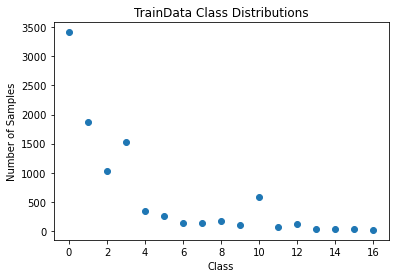

[316. 134. 106. 145.  35.  24.   8.  18.  11.   1.  56.   7.  13.   2.
   7.   6.   0.]


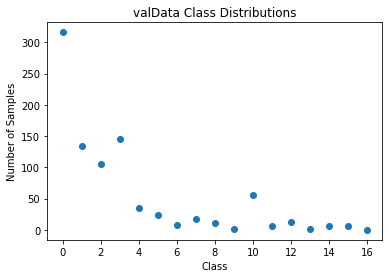

[282. 200.  95. 180.  19.  23.   8.  32.  13.   0.  60.   6.  13.   2.
   4.   3.   0.]


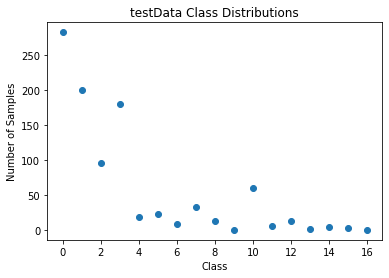

In [27]:
# Print stats from the dataset
for imgs, labels in torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True):
#     print(labels)
    labels = labels

hist_var = np.zeros((17))
for i in range(len(labels)):
#     print(labels[i].numpy())
    #Count each class samples...
    for j in range(0,17):
        if labels[i] == j:
            hist_var[j] += 1
print(hist_var) #Good visual for the demo! (see plot below :) )


plt.plot(np.linspace(0,16,17),hist_var,"o")
plt.ylabel('Number of Samples')
plt.xlabel('Class')
plt.title('TrainData Class Distributions')
plt.show()

for imgs, labels in torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True):
#     print(labels)
    labels = labels

hist_var = np.zeros((17))
for i in range(len(labels)):
#     print(labels[i].numpy())
    #Count each class samples...
    for j in range(0,17):
        if labels[i] == j:
            hist_var[j] += 1
print(hist_var) #Good visual for the demo! (see plot below :) )


plt.plot(np.linspace(0,16,17),hist_var,"o")
plt.ylabel('Number of Samples')
plt.xlabel('Class')
plt.title('valData Class Distributions')
plt.show()

for imgs, labels in torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True):
#     print(labels)
    labels = labels

hist_var = np.zeros((17))
for i in range(len(labels)):
#     print(labels[i].numpy())
    #Count each class samples...
    for j in range(0,17):
        if labels[i] == j:
            hist_var[j] += 1
print(hist_var) #Good visual for the demo! (see plot below :) )


plt.plot(np.linspace(0,16,17),hist_var,"o")
plt.ylabel('Number of Samples')
plt.xlabel('Class')
plt.title('testData Class Distributions')
plt.show()

In [28]:
train_dataset = get_class_binary(train_dataset,0,1)
val_dataset = get_class_binary(val_dataset,0,1)
test_dataset = get_class_binary(test_dataset,0,1)

In [31]:
use_cuda = True

# For LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html #torch.nn.LSTM 
# Hyperparameters
N_FEATURES = 4
N_CLASSES = 2
N_HIDDEN = 32
N_LAYERS = 2
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
LSTM_Net = LSTMClassifier(N_FEATURES, N_CLASSES, N_HIDDEN, N_LAYERS, BATCH_SIZE)
if use_cuda and torch.cuda.is_available():
    LSTM_Net.cuda()

In [32]:
train_losses, train_accs, val_losses, val_accs = train(LSTM_Net, train_dataset, val_dataset, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
  

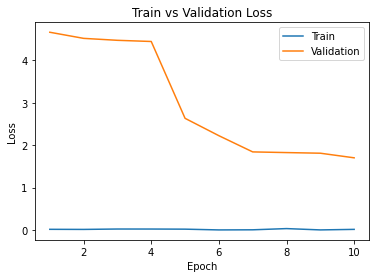

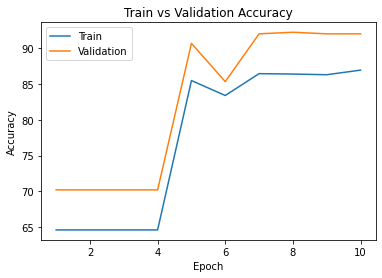

In [33]:
# Plot loss curves
plot_training_curve("Loss", train_losses, val_losses)

# Plot accuracy curves
plot_training_curve("Accuracy", train_accs, val_accs)

## Model Testing

In [34]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

criterion = nn.CrossEntropyLoss()

test_acc = get_accuracy(LSTM_Net, test_loader)
test_loss = get_loss(LSTM_Net, test_loader, criterion)

print(("Test Loss: {:.4f}").format(float(test_loss)))
print(("Test Accuracy: {:.2f}%").format(float(test_acc)))

tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')
Test Loss: 2.0847
Test Accuracy: 89.83%
